# Hypothesis testing in python

In this notebook we are going to cover the basics of frequentist (p-values etc) hypothesis testing in python.

## Who is this notebook aimed at?
This notebook is aimed at people with a very basic knoweldge of python (by that I mean you know how to install using pip etc, load libaraies and code very basic things like declaring functions to an variables). 

Also a very basic understanding of t-tests and ANOVAs would be helpful as this notebook won't go over them in detail.

## The data and what we want to 

The data we have is performance data from individuals with depression, anxiety and controls on two tasks. See the fake data notebook to see more details on how this data was created.

What we want to do is explore potential group differences using python

## Code time

Before we go any further we need to import the libraries we need. We will use scipy.stats to import statistical functions we need, pandas to read in the data, seaborn and matplotlib to plot the data, pingouin and statsmodels.api to test for group differences


In [1]:
import scipy.stats
import pandas as pd
import seaborn as sns
sns.set_style('dark')
import matplotlib.pyplot as plt
import pingouin as pin
import statsmodels.api

## Data exploration

The first thing to do is to read in the data.

In [2]:
df = pd.read_csv('data/task_data.csv')

Next we can explore the data by check for any null vaules and then describing the data using pandas describe method 

In [3]:
df.isnull().any()

task_one    False
task_two    False
Group       False
dtype: bool

In [4]:
df.describe()

,task_one,task_two
count,150.000000,150.000000
mean,1.203144,2.046177
std,0.599466,0.854838
min,0.029288,0.050107
25%,0.781000,1.492856
50%,1.167776,2.082411
75%,1.607271,2.487684
max,2.734936,3.946470


To make it easier later on lets group the controls, anxiety and depression groups into three seperate dataframes and then describe each group.

In [5]:
groups = df.groupby('Group')
controls = groups.get_group('HC')
dep = groups.get_group('DEP')
anx = groups.get_group('ANX')

In [6]:
controls.describe()

,task_one,task_two
count,50.000000,50.000000
mean,0.723176,1.348415
std,0.435999,0.809511
min,0.029288,0.050107
25%,0.412070,0.766595
50%,0.647064,1.325446
75%,1.002347,1.969690
max,1.753900,3.164388


In [7]:
dep.describe()

,task_one,task_two
count,50.000000,50.000000
mean,1.519535,2.055081
std,0.525836,0.455647
min,0.584404,1.072323
25%,1.114924,1.786529
50%,1.440234,2.013727
75%,1.797627,2.353201
max,2.696327,2.977051


In [8]:
anx.describe()

,task_one,task_two
count,50.000000,50.000000
mean,1.366720,2.735035
std,0.511494,0.614858
min,0.249720,1.851753
25%,1.003406,2.247590
50%,1.275888,2.583214
75%,1.631248,3.228751
max,2.734936,3.946470


## Comparisons of two groups

The first thing we are going to do is test for within group differences groups between task one and task two. But before we do we need to test if our data meets the assumptions for parameteric meterics.

Broadly the data needs homogeneity of variance (the variability of the data in each group is similar), of a normal distribution, is continuous and sampled randomly. 

We have seen our data is continuous and it is randomly sampled. However we need to check that the data is normally distributed and homogeneity of variance. 

This will can be done by plotting the distribution and using , as well as scipy.stats.levene (if significant variance differs) test to test  homogeneity of variance

First lets plot the data at time point one (I am doing it by time point or else the graphs get very busy). Seaborn has a kdeplot function to do this 

<Axes: xlabel='task_one', ylabel='Density'>

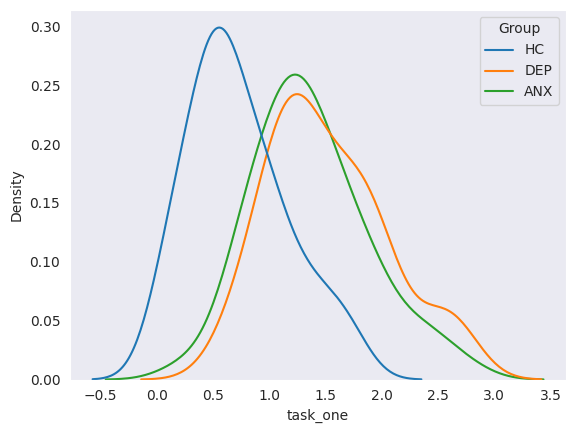

In [9]:
sns.kdeplot(data=df, x='task_one', hue='Group')

<Axes: xlabel='task_two', ylabel='Density'>

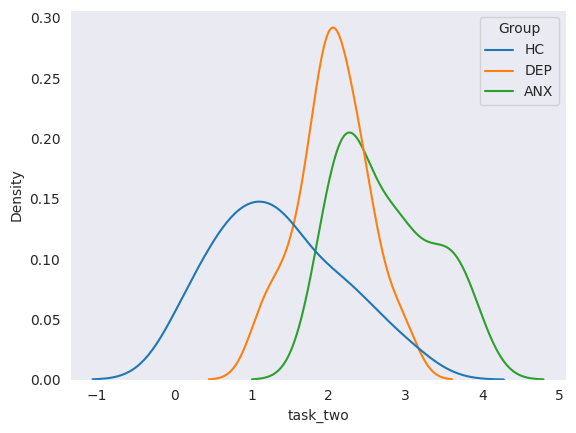

In [10]:
sns.kdeplot(data=df, x='task_two', hue='Group', color='rocket')

For task one the distriubtions all look broadly normally but task two the distutions all look different. Lets use scipy.stats.normaltest  to test if each distubtion is for normal (if significant then the distribution is not normally distibuted)


In [11]:
for column in df.columns:
    if column != 'Group':
        print(f'Controls normal test for {column}', scipy.stats.normaltest(controls[column]))
        print(f'Depressed normal test for {column}', scipy.stats.normaltest(dep[column]))
        print(f'Anxious normal test for {column}', scipy.stats.normaltest(anx[column]))
#scipy.stats.normaltest(data_anx['depressed_anxiety_muam_scores'])

Controls normal test for task_one NormaltestResult(statistic=3.275813775123078, pvalue=0.19438648955174168)
Depressed normal test for task_one NormaltestResult(statistic=2.9920852376949605, pvalue=0.22401492075155147)
Anxious normal test for task_one NormaltestResult(statistic=3.0256363893791303, pvalue=0.2202882870670739)
Controls normal test for task_two NormaltestResult(statistic=2.305952679723562, pvalue=0.31569575182934134)
Depressed normal test for task_two NormaltestResult(statistic=0.12646260611032487, pvalue=0.9387263183103636)
Anxious normal test for task_two NormaltestResult(statistic=9.292686834104947, pvalue=0.009596628721269184)


From this we can see that all the distributions are normal apart from anxious individuals at time point two.

Now lets check to see if the within group distributions have homogeneity of variance (same variance) using scipy.stats.levene test.

In [12]:
print(f'Controls levene test for ', scipy.stats.levene(controls['task_one'], controls['task_two']))
print(f'Depressed levene test for ', scipy.stats.levene(dep['task_one'], dep['task_two']))
print(f'Anxious levene test for ', scipy.stats.levene(anx['task_one'], anx['task_two']))

Controls levene test for  LeveneResult(statistic=16.465525146226863, pvalue=9.963763756500008e-05)
Depressed levene test for  LeveneResult(statistic=1.357496802336857, pvalue=0.24679995169739433)
Anxious levene test for  LeveneResult(statistic=3.9998835027332014, pvalue=0.04827097147515577)


From this we can see that the variance for anxious individuals is equal across time points, but not for the depressed individuals and the controls

We can now test for within-group differences at time points. For depressed individuals we can use a paired-test implemented in pingouin, just make sure to pass 
```paired=True``` 

In [13]:
pin.ttest(dep['task_one'], dep['task_two'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.55538,49,two-sided,0.000001,"[-0.73, -0.34]",1.08852,1.467e+04,1.0


For the other two measures we are going to have to use non-parameteric version, the wilcoxon test.

In [14]:
pin.wilcoxon(anx['task_one'], anx['task_two'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,14.0,two-sided,1.953993e-13,-0.978039,0.038


In [15]:
pin.wilcoxon(controls['task_one'], controls['task_two'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,212.0,two-sided,0.000016,-0.667451,0.2584


## Comparison of three or more groups

We are going to do a between group comparison either using an ANOVA or the non-parameteric version the Kruskal-Wallis H-test.

For an ANOVA we need normally distributed residuals (error term) as well as equal variance.

The great thing about python is we can code all this in one list comprehension. The below code will return the name of the task if an only if the residuals are normally distrubtion and variance and equal. Briefly is does an OLS regression then returns the residuals to check the distribution as well as the levene test mentioned earlier  

In [20]:
from statsmodels.formula.api import ols
measures = ['task_one', 'task_two']
anova = [measure for measure in measures if scipy.stats.normaltest((ols(f'{measure} ~ Group', data=df).fit().resid))[1] > 0.05
              and scipy.stats.levene(anx[measure].dropna(), dep[measure].dropna(), controls[measure].dropna())[1] > 0.05] 

print('The Number of measures that meet the assumptions for ANOVAs:', anova)

The Number of measures that meet the assumptions for ANOVAs: []


We can see niether of the measures meet the assumotions for ANOVAs. For completeness we can plot the residuals for both tasks to check they definetly aren't normally distributied. The ols.resid returns a pandas series which can then be easily manipulated for plotting

<Axes: xlabel='residual', ylabel='Density'>

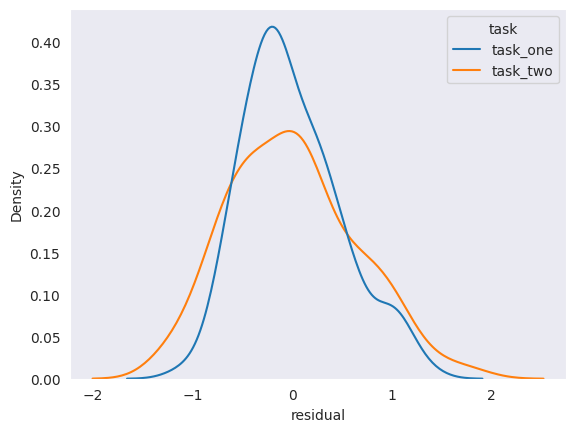

In [35]:
task_one_residuals = pd.DataFrame({'residual': ols('task_one ~ Group', data=df).fit().resid})
task_one_residuals['task'] = 'task_one'
task_two_residuals = pd.DataFrame({'residual': ols('task_two ~ Group', data=df).fit().resid})
task_two_residuals['task'] = 'task_two'

resid_df = pd.concat([task_one_residuals, task_two_residuals])
sns.kdeplot(data=resid_df, x='residual', hue='task')

We can see that the distribtuions don't quite look normal. 

So to test for group difference we are going to use the Kruskal-Wallis H-test. This comes with pingouin.

In [37]:
pin.kruskal(data=df, dv='task_one', between='Group')

,Source,ddof1,H,p-unc
Kruskal,Group,2,52.586532,3.810479e-12


In [38]:
pin.kruskal(data=df, dv='task_two', between='Group')

,Source,ddof1,H,p-unc
Kruskal,Group,2,62.791269,2.317657e-14


We can see that there is a group difference but between which groups?

For sake of easy and consistency we can do three manwhitney-U tests to check which groups do differ. We save these to variables as they are dataframes and then 
we can then use statsmodels.stats.multitest.multipletests to control for multiple comparisons. 

For shake of time I will only do this for task one but just repeat the process for task two if you want!

In [39]:
dep_anx_t1 = pin.mwu(dep['task_one'], anx['task_one'])
dep_controls_t1 = pin.mwu(dep['task_one'], controls['task_one'])
controls_anx_t1 = pin.mwu(controls['task_one'], anx['task_one'])

In [45]:
from statsmodels.stats.multitest import multipletests
multipletests((dep_anx_t1['p-val'][0], dep_controls_t1['p-val'][0], controls_anx_t1['p-val'][0]))

(array([False,  True,  True]),
 array([1.79969819e-01, 1.01798081e-10, 1.98259426e-08]),
 0.016952427508441503,
 0.016666666666666666)

What this returns is information on the p-values after controlling the family-wise-error rate, using the holm-sidak method. Multipletests can control the FWER using a few different methods by passing the method name to ```method=``` (see documentation https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html) 

What multipletests tells us is first are the p-values still significant after controlling the FWER? This is the array of False, True, True and tells us that the p-values are still significant for depressed and anxious individuals between controls but not between each other. 

The next line gives us the new updated p-values. The third and fourth line are not useful in this seceanrio but they give the alpha level if we were using the Sidak and Bonferroni methods respectively. 

## Conclusion

There are so many statistical test and things you can do in python. Anovas for example are as easy to do as Kruskal-Wallis H-test just change the function call.

The main statistical packages in python are statsmodel.api, scipy and pingouin and going on there websites lists all the functions avaiable for hypothesis testing in python!